In [ ]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RepeatedKFold,KFold, cross_val_score
from sklearn.metrics import accuracy_score, make_scorer, recall_score, f1_score, precision_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import zscore
import datetime
from sklearn.metrics import fbeta_score, make_scorer,recall_score
!pip install catboost

from catboost import CatBoostClassifier

In [ ]:
def additional_info(df):
    print("\n",'*** Shape:',df.shape)
    print("\n",'*** Data:',df.head(10))
    print("\n","*** Columns:", df.columns)
    print("\n",'*** Info:')
    df.info()
    print("\n",'*** Missing values:')
    print(df.isnull().sum())
    print("\n",'*** Data Statistics:')
    print(df.describe(include='all'))

# Covid_Study Dataset

In [ ]:
study = pd.read_csv("studyimp.csv")
additional_info(study)


 *** Shape: (279, 16)

 *** Data:    Patient Id  Alanine Aminotransferase (ALT)  \
0         147                        0.023839   
1         160                       -0.746787   
2          57                        4.097148   
3         232                       -0.372483   
4         138                       -0.460555   
5          95                        0.244018   
6         262                       -0.614680   
7         241                        1.499037   
8         191                       -0.592662   
9          62                       -0.086251   

   Aspartate Aminotransferase (AST)  C-Reactive Protein (CRP)  \
0                          1.126748                 -0.428538   
1                         -0.525176                 -0.729870   
2                          0.709420                 -0.864620   
3                         -0.438232                 -0.805203   
4                         -0.420843                  0.286594   
5                         -0.073070

In [ ]:
columns = ['Patient Id', 'Alanine Aminotransferase (ALT)', 'Aspartate Aminotransferase (AST)', 'C-Reactive Protein (CRP)', 'Lactate Dehydrogenase (LDH)','White Blood cell Count (Leukocytes)', 'Lymphocyte Count','Neutrophil Count','Age','Platelets','Basophils','Eosinophils','Monocyte','Alkaline Phosphatase (ALP)','Gamma-glutamyltransferase (GGT)','Class']
study = study.set_axis(columns, axis=1)
study.columns

Index(['Patient Id', 'Alanine Aminotransferase (ALT)',
       'Aspartate Aminotransferase (AST)', 'C-Reactive Protein (CRP)',
       'Lactate Dehydrogenase (LDH)', 'White Blood cell Count (Leukocytes)',
       'Lymphocyte Count', 'Neutrophil Count', 'Age', 'Platelets', 'Basophils',
       'Eosinophils', 'Monocyte', 'Alkaline Phosphatase (ALP)',
       'Gamma-glutamyltransferase (GGT)', 'Class'],
      dtype='object')

In [ ]:
study['Class'].value_counts()

1    177
0    102
Name: Class, dtype: int64

177 Positive Patients
102 Negative Patients

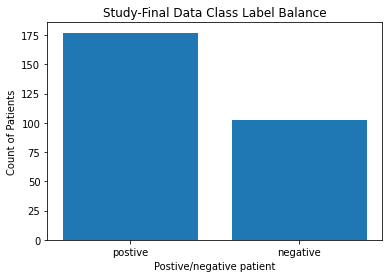

In [ ]:
count_neg = study.Class[study['Class'] == 0].size
count_pos = study.Class[study['Class'] == 1].size

plt.bar(['postive', 'negative'], [count_pos, count_neg])
plt.title('Study-Final Data Class Label Balance')
plt.xlabel('Postive/negative patient')
plt.ylabel('Count of Patients')
plt.show()

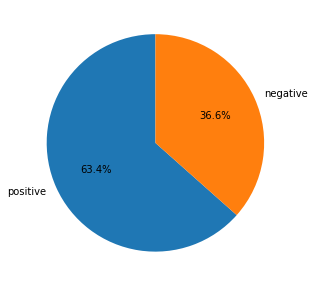

In [ ]:
labels = ['positive', 'negative']
sizes = [count_pos, count_neg]
fig1, ax1 = plt.subplots(1,1, figsize=(5,5))
wedges, text, autotexts = ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.show()

## Imputing Values

In [ ]:
#Simple Imputer
imputer = SimpleImputer(missing_values = np.NaN, strategy ='most_frequent')
imputer = imputer.fit(study)

# Imputing the data
study = imputer.transform(study)
study = pd.DataFrame(data=study, columns=columns)
study.head(10)

,Patient Id,Alanine Aminotransferase (ALT),Aspartate Aminotransferase (AST),C-Reactive Protein (CRP),Lactate Dehydrogenase (LDH),White Blood cell Count (Leukocytes),Lymphocyte Count,Neutrophil Count,Age,Platelets,Basophils,Eosinophils,Monocyte,Alkaline Phosphatase (ALP),Gamma-glutamyltransferase (GGT),Class
0,147.0,0.023839,1.126748,-0.428538,0.225092,-0.980705,0.145728,-0.985079,76.0,-1.302409,-0.369611,-0.417099,-0.747413,0.508251,0.828371,1.0
1,160.0,-0.746787,-0.525176,-0.729870,-0.307254,-0.898173,1.015934,-1.033126,90.0,-1.995538,-0.369611,-0.417099,-0.747413,-0.246685,-0.427172,1.0
2,57.0,4.097148,0.709420,-0.864620,-0.446801,-0.176015,-0.227217,-0.120233,76.0,2.608815,2.193023,-0.417099,0.719341,-0.246685,-0.291028,1.0
3,232.0,-0.372483,-0.438232,-0.805203,-0.307254,-0.237914,-0.227217,-0.576679,91.0,-0.034975,-0.369611,-0.417099,-0.502954,-0.246685,-0.427172,0.0
4,138.0,-0.460555,-0.420843,0.286594,-0.379612,-0.733108,-0.848792,-0.456562,68.0,-0.539968,-0.369611,-0.417099,-0.991872,-0.348095,-0.434735,1.0
5,95.0,0.244018,-0.073070,0.082877,-0.291749,-0.691842,-0.600162,-0.528632,40.0,-0.401342,-0.369611,-0.417099,-0.258495,-0.348095,-0.011178,1.0
6,262.0,-0.614680,-0.316511,-0.678941,-0.307254,1.206403,0.270043,1.104967,84.0,0.014535,-0.369611,0.340933,3.408390,-0.246685,-0.427172,0.0
7,241.0,1.499037,0.031262,0.405429,-0.307254,2.712620,-0.227217,-0.576679,48.0,0.856191,-0.369611,-0.417099,-0.502954,-0.246685,-0.427172,0.0
8,191.0,-0.592662,-0.716451,-0.956930,-0.927464,0.277914,2.632030,-0.120233,32.0,-0.361735,2.193023,1.856999,-0.014036,-0.246685,-0.427172,0.0
9,62.0,-0.086251,0.239926,-0.031714,1.165744,-0.753741,-0.600162,-0.528632,70.0,-0.807318,-0.369611,-0.417099,-0.747413,-0.010064,-0.147322,1.0


## ZScore Outlier Removal

In [ ]:
new_data = study.copy(deep=True)
z_scores = abs(zscore(new_data))
filtered = (z_scores<3.0).all(axis=1)
new_df = new_data[filtered]
new_df.shape

(237, 16)

In [ ]:
new_df['Class'].value_counts()

1.0    151
0.0     86
Name: Class, dtype: int64

### New Outlier Removal

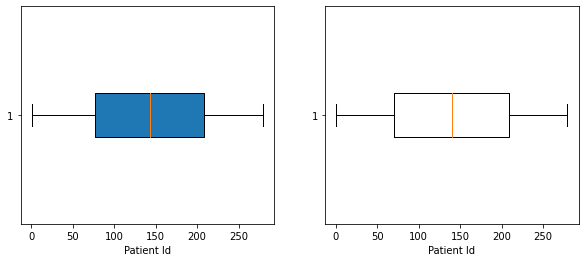

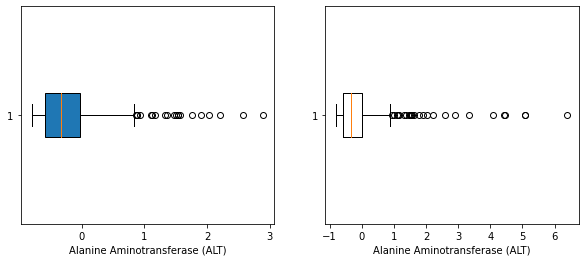

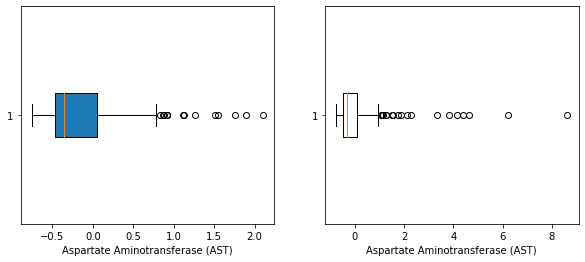

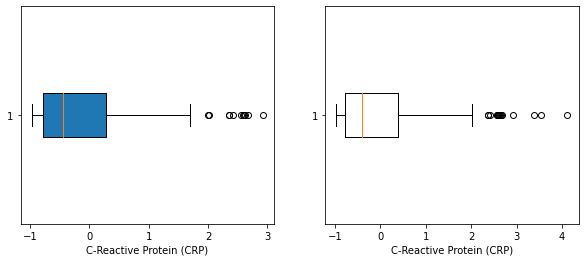

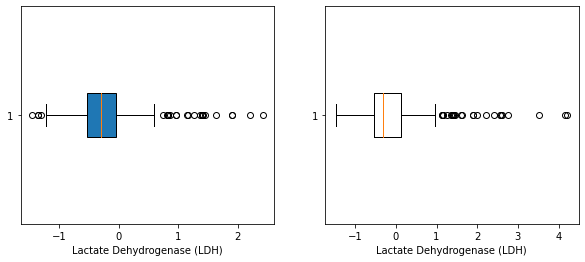

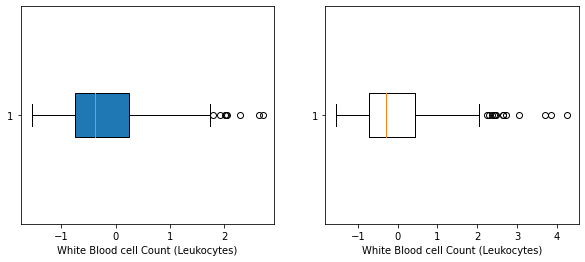

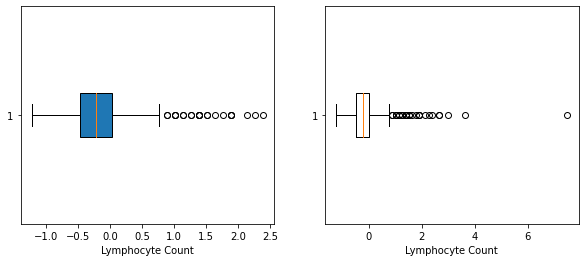

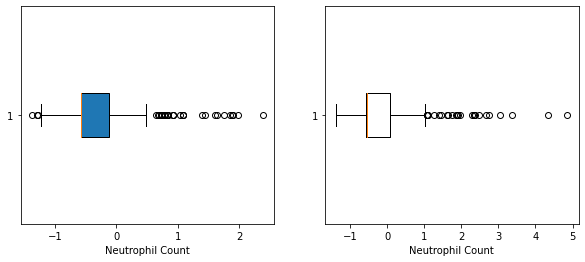

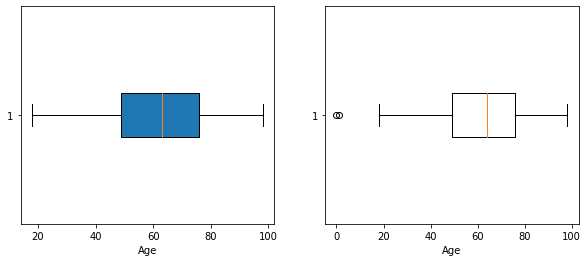

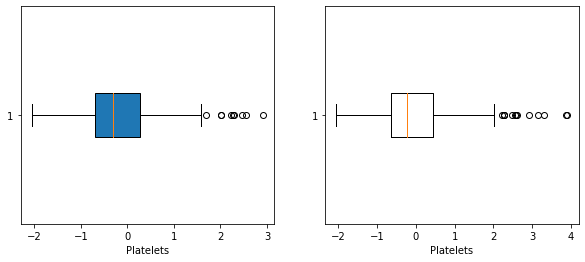

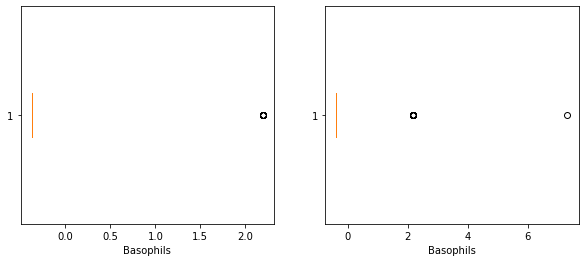

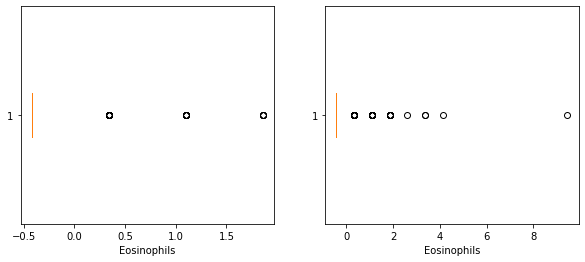

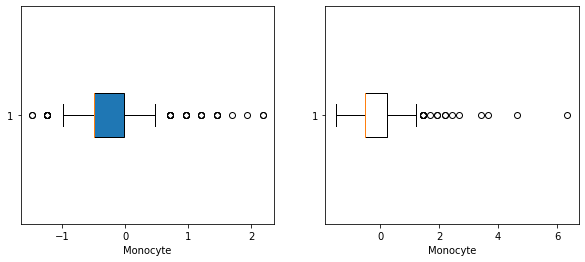

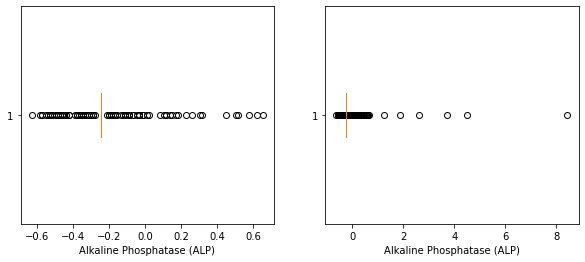

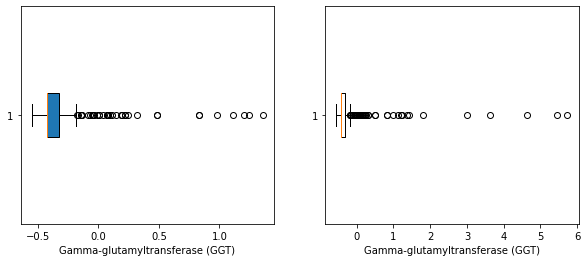

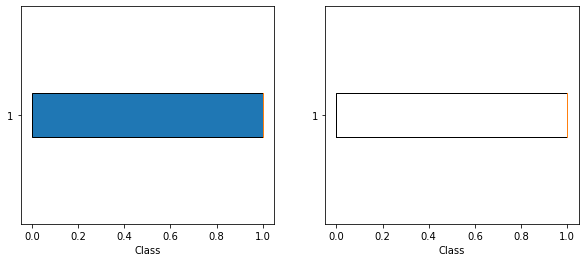

In [ ]:
for col in range(len(new_data.columns)):
    fig, axes = plt.subplots(1,2,figsize=(10,4))
    axes[0].boxplot(new_df[new_data.columns[col]], vert=False, widths=0.2, patch_artist=True)
    axes[1].boxplot(study[new_data.columns[col]], vert=False, widths=0.2)
    axes[0].set_xlabel(new_data.columns[col])
    axes[1].set_xlabel(new_data.columns[col])
    plt.show()

## Part 2: Implementation 

In [ ]:
scores = {'Algos':['RFC', 'XGB','LGBM','CatB','VC'], 'Specificity':[], 'Sensitivity':[], 'Precision':[], 'F1':[]}

In [ ]:
X = new_data.drop(['Class'], axis = 1)
y = new_data['Class']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=10)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(223, 15) (56, 15) (223,) (56,)


In [ ]:
RF_ = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None, criterion='gini', max_depth=3, 
                             max_features='auto', max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0, 
                             min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100, 
                             n_jobs=None, oob_score=False, random_state=1, verbose=0, warm_start=False)

XGBOOST_ = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, 
                         gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=12, min_child_weight=1, missing=None, 
                         n_estimators=10, n_jobs=1, nthread=None, objective='binary:logistic', random_state=1, reg_alpha=0, 
                         reg_lambda=1, scale_pos_weight=1, seed=None, silent=None, subsample=1, verbosity=1)

LGBM_ = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0, importance_type='split', learning_rate=0.01,
                       max_depth=5, min_child_samples=20, min_child_weight=0.01, min_split_gain=0.0, n_estimators=50, n_jobs=-1, 
                       num_leaves=31, objective=None, random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0, 
                       subsample_for_bin=200000, subsample_freq=0)

CATB_ = CatBoostClassifier(n_estimators=50, max_depth=3, learning_rate=0.01, random_strength=1)

models = [('RF',RF_),('XGBOOST',XGBOOST_),('LGBM',LGBM_), ('CATBOOST',CATB_)]

In [ ]:
cv = RepeatedKFold(n_splits = 2, n_repeats = 5)

In [ ]:
def score(model):
    if model=="vc":
        clf=VotingClassifier(estimators=models, voting='soft')
    else:
        clf=model

    cv = RepeatedKFold(n_splits=2, n_repeats=5, random_state=1)
    
    for train_idx, val_idx in cv.split(X_train,y_train):
        train_X, val_X = X_train.iloc[train_idx, :], X_train.iloc[val_idx, :]
        train_y, val_y = y_train.iloc[train_idx], y_train.iloc[val_idx]
        clf.fit(train_X, train_y)
    
    specificity = make_scorer(recall_score, pos_label=0)
    spc_score = cross_val_score(clf, X_test, y_test, cv=cv, scoring=specificity)

    sensitivity = make_scorer(recall_score, pos_label=1)
    sns_score = cross_val_score(clf, X_test, y_test, cv=cv, scoring=sensitivity)
    
    prs_score = cross_val_score(clf, X_test, y_test, cv=cv, scoring='precision')
    
    f1_score = cross_val_score(clf, X_test, y_test, cv=cv, scoring='f1')
    
    return spc_score, sns_score, prs_score, f1_score

In [ ]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

## RandomForest 

In [ ]:
rf_params={
 "max_depth"    : [3, 5, 8, 10, 12, 15],
 "n_estimators" : [5, 10, 20, 50, 100, 150] 
}

In [ ]:
model = RandomForestClassifier(random_state=1)

random_search = RandomizedSearchCV(model, param_distributions=rf_params, n_iter=3,scoring='f1',n_jobs=-1,cv=cv, random_state=3)

start = time.time()
random_search.fit(X_train,y_train)
print("time taken: ", time.time()-start)

print("Best Params: ",random_search.best_params_)

time taken:  3.7537920475006104
Best Params:  {'n_estimators': 100, 'max_depth': 3}


In [ ]:
model_rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=1)

spc, sns, prs, f1 = score(model_rf)
spc_score = round((np.mean(spc)*100.0), 2)
sns_score = round((np.mean(sns)*100.0),2)
prs_score = round((np.mean(prs)*100.0),2)
f1_score = round((np.mean(f1)*100.0),2)

scores['Specificity'].append(spc_score)
scores['Sensitivity'].append(sns_score)
scores['Precision'].append(prs_score)
scores['F1'].append(f1_score)

print("Specificity: ")
print(spc_score,"%")
print("Sensitivity (Recall): ")
print(sns_score,"%")
print("Precision: ")
print(prs_score,"%")
print("F1-Score: ")
print(f1_score,"%")

Specificity: 
91.13 %
Sensitivity (Recall): 
97.76 %
Precision: 
93.63 %
F1-Score: 
95.49 %


## Boosting Algorithms

In [ ]:
params={
 "learning_rate"    : [0.01, 0.05, 0.10, 0.15, 0.20],
 "max_depth"        : [3, 5, 8, 10, 12, 15],
 "n_estimators"     : [5, 10, 20, 50, 100, 150] 
}

### XGBoost

In [ ]:
xgb = XGBClassifier(random_state=1)

In [ ]:
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=3,scoring='f1',n_jobs=-1,cv=cv, random_state=3)

In [ ]:
start = time.time()
random_search.fit(X_train,y_train)
print("time taken: ", time.time()-start)

print("Best Params: ",random_search.best_params_)

time taken:  0.537226676940918
Best Params:  {'n_estimators': 10, 'max_depth': 12, 'learning_rate': 0.01}


In [ ]:
model_xgb =  XGBClassifier(n_estimators= 10, max_depth= 12, learning_rate=0.01, random_state=1)

In [ ]:
spc, sns, prs, f1 = score(model_xgb)

spc_score = round((np.mean(spc)*100.0), 2)
sns_score = round((np.mean(sns)*100.0),2)
prs_score = round((np.mean(prs)*100.0),2)
f1_score = round((np.mean(f1)*100.0),2)

scores['Specificity'].append(spc_score)
scores['Sensitivity'].append(sns_score)
scores['Precision'].append(prs_score)
scores['F1'].append(f1_score)

print("Specificity: ")
print(spc_score,"%")
print("Sensitivity (Recall): ")
print(sns_score,"%")
print("Precision: ")
print(prs_score,"%")
print("F1-Score: ")
print(f1_score,"%")

Specificity: 
96.58 %
Sensitivity (Recall): 
96.66 %
Precision: 
97.83 %
F1-Score: 
97.09 %


### LightGBM

In [ ]:
lgb = LGBMClassifier(random_state=1)

In [ ]:
random_search = RandomizedSearchCV(lgb, param_distributions=params, n_iter=3,scoring='f1',n_jobs=-1,cv=cv, random_state=3)

In [ ]:
start = time.time()
random_search.fit(X_train,y_train)
print("time taken: ", time.time()-start)

print("Best Params: ",random_search.best_params_)

time taken:  0.6825377941131592
Best Params:  {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01}


In [ ]:
model_lgb =  LGBMClassifier(n_estimators= 50, max_depth=3, learning_rate=0.01, random_state=1)

In [ ]:
spc, sns, prs, f1 = score(model_lgb)

spc_score = round((np.mean(spc)*100.0), 2)
sns_score = round((np.mean(sns)*100.0),2)
prs_score = round((np.mean(prs)*100.0),2)
f1_score = round((np.mean(f1)*100.0),2)

scores['Specificity'].append(spc_score)
scores['Sensitivity'].append(sns_score)
scores['Precision'].append(prs_score)
scores['F1'].append(f1_score)

print("Specificity: ")
print(spc_score,"%")
print("Sensitivity (Recall): ")
print(sns_score,"%")
print("Precision: ")
print(prs_score,"%")
print("F1-Score: ")
print(f1_score,"%")

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Specificity: 
10.0 %
Sensitivity (Recall): 
90.0 %
Precision: 
53.57 %
F1-Score: 
66.95 %


### Catboost

In [ ]:
cb = CatBoostClassifier(random_strength=1)

In [ ]:
random_search = RandomizedSearchCV(cb, param_distributions=params, n_iter=3,scoring='f1',n_jobs=-1,cv=cv, random_state=3)

In [ ]:
start = time.time()
random_search.fit(X_train,y_train)
print("time taken: ", time.time()-start)

print("Best Params: ",random_search.best_params_)

0:	learn: 0.6855520	total: 47.4ms	remaining: 2.32s
1:	learn: 0.6788643	total: 48.6ms	remaining: 1.17s
2:	learn: 0.6713931	total: 49.3ms	remaining: 772ms
3:	learn: 0.6643757	total: 50.5ms	remaining: 581ms
4:	learn: 0.6574987	total: 52ms	remaining: 468ms
5:	learn: 0.6508638	total: 52.7ms	remaining: 386ms
6:	learn: 0.6437274	total: 53.3ms	remaining: 328ms
7:	learn: 0.6371262	total: 54.1ms	remaining: 284ms
8:	learn: 0.6308061	total: 56.5ms	remaining: 258ms
9:	learn: 0.6236960	total: 57.2ms	remaining: 229ms
10:	learn: 0.6174057	total: 57.9ms	remaining: 205ms
11:	learn: 0.6112766	total: 58.6ms	remaining: 186ms
12:	learn: 0.6045444	total: 59.3ms	remaining: 169ms
13:	learn: 0.5985246	total: 64.5ms	remaining: 166ms
14:	learn: 0.5923317	total: 65.3ms	remaining: 152ms
15:	learn: 0.5856136	total: 66ms	remaining: 140ms
16:	learn: 0.5797958	total: 66.7ms	remaining: 129ms
17:	learn: 0.5736090	total: 67.4ms	remaining: 120ms
18:	learn: 0.5677928	total: 68.1ms	remaining: 111ms
19:	learn: 0.5616969	total

In [ ]:
model_cb =  CatBoostClassifier(n_estimators=50, max_depth=3, learning_rate=0.01)

In [ ]:
spc, sns, prs, f1 = score(model_cb)

spc_score = round((np.mean(spc)*100.0), 2)
sns_score = round((np.mean(sns)*100.0),2)
prs_score = round((np.mean(prs)*100.0),2)
f1_score = round((np.mean(f1)*100.0),2)

scores['Specificity'].append(spc_score)
scores['Sensitivity'].append(sns_score)
scores['Precision'].append(prs_score)
scores['F1'].append(f1_score)

print("Specificity: ")
print(spc_score,"%")
print("Sensitivity (Recall): ")
print(sns_score,"%")
print("Precision: ")
print(prs_score,"%")
print("F1-Score: ")
print(f1_score,"%")

0:	learn: 0.6887511	total: 478us	remaining: 23.4ms
1:	learn: 0.6831773	total: 866us	remaining: 20.8ms
2:	learn: 0.6766039	total: 1.21ms	remaining: 19ms
3:	learn: 0.6696736	total: 1.57ms	remaining: 18.1ms
4:	learn: 0.6633117	total: 1.92ms	remaining: 17.3ms
5:	learn: 0.6569915	total: 2.25ms	remaining: 16.5ms
6:	learn: 0.6520554	total: 2.6ms	remaining: 16ms
7:	learn: 0.6462659	total: 2.94ms	remaining: 15.4ms
8:	learn: 0.6406024	total: 3.27ms	remaining: 14.9ms
9:	learn: 0.6355130	total: 3.61ms	remaining: 14.4ms
10:	learn: 0.6303314	total: 3.94ms	remaining: 14ms
11:	learn: 0.6246109	total: 4.29ms	remaining: 13.6ms
12:	learn: 0.6203088	total: 4.62ms	remaining: 13.2ms
13:	learn: 0.6150495	total: 4.96ms	remaining: 12.8ms
14:	learn: 0.6089993	total: 5.3ms	remaining: 12.4ms
15:	learn: 0.6042575	total: 5.63ms	remaining: 12ms
16:	learn: 0.6009177	total: 5.98ms	remaining: 11.6ms
17:	learn: 0.5956955	total: 6.51ms	remaining: 11.6ms
18:	learn: 0.5908482	total: 7.07ms	remaining: 11.5ms
19:	learn: 0.58

###Voting Classifier

In [ ]:
spc, sns, prs, f1 = score("vc")

0:	learn: 0.6887511	total: 465us	remaining: 22.8ms
1:	learn: 0.6831773	total: 1.57ms	remaining: 37.8ms
2:	learn: 0.6766039	total: 2.22ms	remaining: 34.8ms
3:	learn: 0.6696736	total: 2.8ms	remaining: 32.2ms
4:	learn: 0.6633117	total: 3.4ms	remaining: 30.6ms
5:	learn: 0.6569915	total: 3.99ms	remaining: 29.2ms
6:	learn: 0.6520554	total: 4.54ms	remaining: 27.9ms
7:	learn: 0.6462659	total: 5.1ms	remaining: 26.8ms
8:	learn: 0.6406024	total: 5.68ms	remaining: 25.9ms
9:	learn: 0.6355130	total: 6.26ms	remaining: 25ms
10:	learn: 0.6303314	total: 6.79ms	remaining: 24.1ms
11:	learn: 0.6246109	total: 7.34ms	remaining: 23.3ms
12:	learn: 0.6203088	total: 7.91ms	remaining: 22.5ms
13:	learn: 0.6150495	total: 8.45ms	remaining: 21.7ms
14:	learn: 0.6089993	total: 9.02ms	remaining: 21ms
15:	learn: 0.6042575	total: 9.59ms	remaining: 20.4ms
16:	learn: 0.6009177	total: 10.1ms	remaining: 19.7ms
17:	learn: 0.5956955	total: 10.7ms	remaining: 19ms
18:	learn: 0.5908482	total: 11.3ms	remaining: 18.4ms
19:	learn: 0.

In [ ]:
spc_score = round((np.mean(spc)*100.0), 2)
sns_score = round((np.mean(sns)*100.0),2)
prs_score = round((np.mean(prs)*100.0),2)
f1_score = round((np.mean(f1)*100.0),2)

scores['Specificity'].append(spc_score)
scores['Sensitivity'].append(sns_score)
scores['Precision'].append(prs_score)
scores['F1'].append(f1_score)

print("Specificity: ")
print(spc_score,"%")
print("Sensitivity (Recall): ")
print(sns_score,"%")
print("Precision: ")
print(prs_score,"%")
print("F1-Score: ")
print(f1_score,"%")

Specificity: 
83.99 %
Sensitivity (Recall): 
98.47 %
Precision: 
89.23 %
F1-Score: 
93.1 %


###Graphs

In [ ]:
results = pd.DataFrame(scores)
resm = results.melt('Algos', var_name='Metrics', value_name='values')
resm

,Algos,Metrics,values
0,RFC,Specificity,91.13
1,XGB,Specificity,96.58
2,LGBM,Specificity,10.00
3,CatB,Specificity,96.58
4,VC,Specificity,83.99
5,RFC,Sensitivity,97.76
6,XGB,Sensitivity,96.66
7,LGBM,Sensitivity,90.00
8,CatB,Sensitivity,98.47
9,VC,Sensitivity,98.47


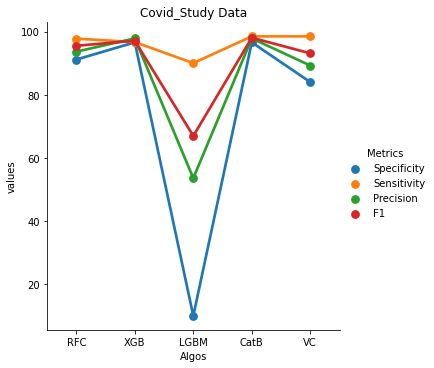

In [ ]:
sns.catplot(x='Algos', y="values", hue="Metrics", data=resm, kind="point").set(title="Covid_Study Data")